## Tumor suppressor genes locating near *POLR3G* on the same chromosome

*POLR3G* locates on the chromosomes 5 (chr5q14.3)

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

In [9]:
cgc = pd.read_csv('/Users/amy/Desktop/SyntheticLethalityProject/sources/Census_all.csv', index_col = None)
bailey = pd.read_excel('/Users/amy/Desktop/SyntheticLethalityProject/sources/Bailey_TableS1.xlsx', index_col = None)
hgnc = pd.read_table('/Users/amy/Desktop/SyntheticLethalityProject/sources/hgnc_gene_with_protein_product.txt', index_col = None, low_memory=False)

In [10]:
hgnc = hgnc[['location', 'symbol']]
hgnc = hgnc.rename(columns = {'symbol':'Gene'})
hgnc[:2]

,location,Gene
0,19q13.43,A1BG
1,10q11.23,A1CF


In [11]:
cgc[:2]

,Gene Symbol,Name,Entrez GeneId,Genome Location,Tier,Hallmark,Chr Band,Somatic,Germline,Tumour Types(Somatic),Tumour Types(Germline),Cancer Syndrome,Tissue Type,Molecular Genetics,Role in Cancer,Mutation Types,Translocation Partner,Other Germline Mut,Other Syndrome,Synonyms
0,A1CF,APOBEC1 complementation factor,29974.0,10:50799421-50885675,2,NaN,11.23,yes,NaN,melanoma,NaN,NaN,E,NaN,oncogene,Mis,NaN,NaN,NaN,"ACF,ACF64,ACF65,APOBEC1CF,ASP,CCDS73133.1,ENSG..."
1,ABI1,abl-interactor 1,10006.0,10:26746593-26860935,1,Yes,12.10,yes,NaN,AML,NaN,NaN,L,Dom,"TSG, fusion",T,KMT2A,NaN,NaN,"ABI-1,CCDS7150.1,E3B1,ENSG00000136754.17,NM_00..."


In [12]:
bailey[:2]

,Gene,Cancer,KEY,Tumor suppressor or oncogene prediction (by 20/20+),Decision,Tissue Frequency,Pancan Frequency,Consensus Score,Correlation adusted score,Novel,Rescue Notes,Note about previous publication
0,ABL1,PANCAN,ABL1_PANCAN,NaN,rescued,NaN,0.011675,0.0,NaN,0,Evidence from OncoImpact/DriverNET overlap (SN...,NaN
1,ACVR1,UCEC,ACVR1_UCEC,oncogene,official,0.05303,0.007490,1.5,1.5,0,NaN,0


In [13]:
## TSGs in CGC data
cgc_tsg = cgc[(cgc['Role in Cancer'] == 'TSG') | (cgc['Role in Cancer'] == '')]
cgc_tsg = cgc_tsg[['Gene Symbol']]
cgc_tsg = cgc_tsg.rename(columns = {'Gene Symbol':'Gene'})

## TSGs in Bailey et al. study
bailey_tsg = bailey[(bailey['Tumor suppressor or oncogene prediction (by 20/20+)'] == 'tsg') |
                    (bailey['Tumor suppressor or oncogene prediction (by 20/20+)'] == 'possible tsg')]

bailey_tsg = bailey_tsg[['Gene']]

tsg = pd.concat([bailey_tsg, cgc_tsg]).drop_duplicates(subset = ['Gene']).reset_index(drop=True)

tsg_ls = pd.merge(hgnc, tsg, on = ['Gene'], how = 'right')

tsg_ls[:5]

,location,Gene
0,12q13.13,ACVR1B
1,2q22.3-q23.1,ACVR2A
2,14q11.2,AJUBA
3,4q13.3,ALB
4,Xq11.2,AMER1


In [14]:
print('Number of TSGs:', tsg.shape[0])

Number of TSGs: 281


In [15]:
## TSGs on chromosome 5
chr5_tsg = tsg_ls[tsg_ls['location'].str[0] == '5'].reset_index(drop=True)
# chr5_tsg = chr5_tsg.rename(columns = {'TSG':'Gene'})
chr5_tsg.to_csv('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/09_tsg_near_polr3g/chr5_tsg.csv', index = False)

**How frequently that *POLR3G* and TSGs on chromosome 5 are codeleted?**

In [16]:
## CNA of tsgs
chr5_tsg_CNA = pd.read_table('/Users/amy/Desktop/SyntheticLethalityProject/sources/chr5_tsg_CNA.txt', index_col= None)
## CNA of polr3g
SLs_A2_CNA = pd.read_table('/Users/amy/Desktop/SyntheticLethalityProject/sources/SLs_A2_CNA.txt', index_col = None)
## TSGs on chr5
chr5_tsg = pd.read_csv('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/09_tsg_near_polr3g/chr5_tsg.csv', index_col = None)

# Study code abbreviation
tcga_study_codes = pd.read_table('/Users/amy/Desktop/SyntheticLethalityProject/sources/tcga_study_abbreviations.txt', index_col = None)
# Add code for Colorectal Adenocarcinoma
tcga_study_codes.loc[37] = ['COADREAD','Colorectal Adenocarcinoma']
tcga_study_codes[:5]

,Study Abbreviation,Study Name
0,LAML,Acute Myeloid Leukemia
1,ACC,Adrenocortical carcinoma
2,BLCA,Bladder Urothelial Carcinoma
3,LGG,Brain Lower Grade Glioma
4,BRCA,Breast invasive carcinoma


In [17]:
## Get the study code of the TCGA sample 
chr5_tsg_CNA['Study Abbreviation'] = chr5_tsg_CNA['STUDY_ID'].apply(lambda x: x.split('_')[0].upper())
chr5_tsg_CNA = chr5_tsg_CNA.drop('STUDY_ID', axis = 1)
SLs_A2_CNA['Study Abbreviation'] = SLs_A2_CNA['STUDY_ID'].apply(lambda x: x.split('_')[0].upper())

## polr3g CNA
polr3g_CNA = SLs_A2_CNA[['SAMPLE_ID', 'POLR3G']]

## merge polr3g and tsgs CNA together
tsg_polr3g_CNA = pd.merge(polr3g_CNA, chr5_tsg_CNA, on = ['SAMPLE_ID'], how = 'left')
tsg_polr3g_CNA = pd.merge(tcga_study_codes,tsg_polr3g_CNA, on = ['Study Abbreviation'], how = 'left')
tsg_polr3g_CNA[:2]
tsg_polr3g_CNA.to_csv('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/09_tsg_near_polr3g/tsg_polr3g_CNA.csv', index=False)

In [18]:
## Percentage of gene loss
gene_loss_in_ct = pd.read_csv('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/08_gene_loss_in_tcga/percentage_gene_loss_in_cancerType.csv', index_col = None)
gene_loss_in_ct = gene_loss_in_ct[(gene_loss_in_ct['gene_pair'] == 'POLR3GL_POLR3G') & (gene_loss_in_ct['deletion_frequency'] > 1)]
gene_loss_in_ct[:8]

,cancer_type,deletion_frequency,A2,gene_pair
275,Ovarian serous cystadenocarcinoma,3.321678,POLR3G,POLR3GL_POLR3G
276,Prostate adenocarcinoma,2.044990,POLR3G,POLR3GL_POLR3G
277,Esophageal carcinoma,1.098901,POLR3G,POLR3GL_POLR3G
278,Lung squamous cell carcinoma,1.026694,POLR3G,POLR3GL_POLR3G
279,Colorectal Adenocarcinoma,1.013514,POLR3G,POLR3GL_POLR3G


In [19]:
ct = gene_loss_in_ct.cancer_type.unique()

tsg_polr3g_CNA = pd.read_csv('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/09_tsg_near_polr3g/tsg_polr3g_CNA.csv', index_col=None)
tsg_symbol = chr5_tsg.Gene

for cancer_type in ct:
    tsg_polr3g_CNA_ct = tsg_polr3g_CNA[tsg_polr3g_CNA['Study Name'] == cancer_type]
    
    for i in range(len(tsg_symbol)):
    
        tsg = tsg_symbol[i]
        tsg_polr3g = tsg_polr3g_CNA_ct[['POLR3G', tsg, 'Study Abbreviation', 'Study Name']]
        # Clean the data (remove NA and NP)
        tsg_polr3g = tsg_polr3g[~((tsg_polr3g['POLR3G']=='NP') | (tsg_polr3g[tsg]=='NP'))]
        tsg_polr3g = tsg_polr3g.dropna(subset = ['POLR3G', tsg])
        tsg_polr3g = tsg_polr3g.astype({'POLR3G':'int', tsg:'int'})

        ## cnot7deletion, % of TSGs deletion
        polr3g_dele = tsg_polr3g[tsg_polr3g['POLR3G'] == -2]
        polr3g_dele = pd.DataFrame(polr3g_dele)
        polr3g_dele.loc[:,'TSG_dele'] = polr3g_dele[tsg] == -2 

        # Calculate the percentage of codeletion in each cancer type
        if polr3g_dele.shape[0] == 0:
            continue
        
        tsg_del_freq = (sum(polr3g_dele.TSG_dele) / polr3g_dele.shape[0]) * 100


        if i == 0:
            codele_freq = {'TSG':[tsg], str(tsg_polr3g['Study Abbreviation'].iloc[0]):[tsg_del_freq]}
            codele_freq_df_ct = pd.DataFrame(codele_freq)
        else:
            codele_freq_df_ct.loc[i] = [tsg, tsg_del_freq]
            
    
    if cancer_type == 'Ovarian serous cystadenocarcinoma':
        
        codele_freq_df = codele_freq_df_ct
    
    else:
        
        codele_freq_df = pd.concat([codele_freq_df, codele_freq_df_ct.iloc[:,1]],axis=1)
        



In [20]:
## Tidy up the deletion frequency table
chr5_tsg = chr5_tsg.rename(columns = {'Gene':'TSG'})
codele_freq_df = pd.merge(codele_freq_df, chr5_tsg, on= ['TSG'], how = 'right')

# codele_freq_df.to_csv('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/09_tsg_near_polr3g/polr3g_tsg_codele_freq.csv', index=False)
# codele_freq_df = pd.read_csv('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/09_tsg_near_polr3g/polr3g_tsg_codele_freq.csv', index_col =None)

tsg_p = codele_freq_df[codele_freq_df['location'].str[1] == 'p'].sort_values(by = ['location'], ascending = False).reset_index(drop=True)
tsg_q = codele_freq_df[codele_freq_df['location'].str[1] == 'q'].sort_values(by = ['location'], ascending = True).reset_index(drop=True)
codele_freq_df = pd.concat([tsg_p, tsg_q]).reset_index(drop=True)
pd.DataFrame(codele_freq_df).loc[:,'x_label'] = codele_freq_df['TSG'].astype(str).str.cat(codele_freq_df['location'].astype(str), sep=' ')
codele_freq_df

,TSG,OV,PRAD,ESCA,LUSC,COADREAD,location,x_label
0,SDHA,0.000000,0.0,0.0,0.0,0.000000,5p15.33,SDHA 5p15.33
1,CDH10,0.000000,0.0,0.0,0.0,0.000000,5p14.2-p14.1,CDH10 5p14.2-p14.1
2,DROSHA,0.000000,0.0,0.0,0.0,0.000000,5p13.3,DROSHA 5p13.3
3,NIPBL,0.000000,0.0,0.0,0.0,0.000000,5p13.2,NIPBL 5p13.2
4,IL6ST,31.578947,40.0,100.0,20.0,0.000000,5q11.2,IL6ST 5q11.2
5,MAP3K1,31.578947,40.0,100.0,20.0,0.000000,5q11.2,MAP3K1 5q11.2
6,PIK3R1,47.368421,50.0,100.0,40.0,16.666667,5q13.1,PIK3R1 5q13.1
7,RAD17,52.631579,50.0,100.0,40.0,16.666667,5q13.2,RAD17 5q13.2
8,RASA1,94.736842,60.0,100.0,60.0,83.333333,5q14.3,RASA1 5q14.3
9,APC,42.105263,40.0,0.0,60.0,33.333333,5q22.2,APC 5q22.2


In [14]:
def draw_del_freq(plt_df, summary_sample_df):
    
    f, ax = plt.subplots(1, 1, figsize=(4.6,3))
    plt_df = plt_df.rename(columns={plt_df.columns[1]:'TSG_del_freq'})
    plt.suptitle(str(summary_sample_df[summary_sample_df['POLR3G'] == '-2'].shape[0])+' samples with $\t{POLR3G}$ HD in '+str(summary_sample_df['Study Abbreviation'].iloc[1]), 
                  horizontalalignment='center', fontsize = 15, y = 1.05)


    ax = sns.barplot(x = 'x_label', y = 'TSG_del_freq', data = plt_df, ax = ax, width = 0.7, 
                     palette=['#CCCCCC', '#CCCCCC', '#CCCCCC', '#CCCCCC',
                              '#CCCCCC', '#CCCCCC', '#CCCCCC', '#CCCCCC',
                              '#F44E3B', '#CCCCCC', '#CCCCCC'])


    ax.set_ylabel('% of TSG deletion in \n $\it{POLR3G}$ HD samples', fontsize=12)
    ax.set_xlabel('')
    ax.set_xticklabels(plt_df.x_label, fontsize=12)
    # Spine of the plot 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.xticks(rotation=90)
    
    ## Save plot to a Figure object
    fig_output = plt.gcf()
    # Close the plot to release memory
    plt.close()

    return fig_output

**Ovarian serous carcinoma**

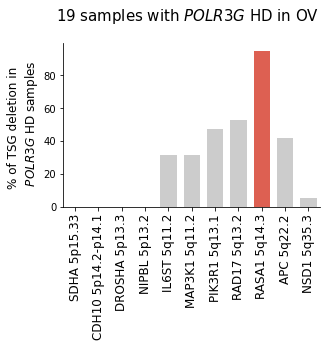

In [15]:
plt_df = codele_freq_df[['TSG', 'OV', 'x_label']]
summary_sample_df = tsg_polr3g_CNA[tsg_polr3g_CNA['Study Abbreviation'] == 'OV']
fig_output = draw_del_freq(plt_df, summary_sample_df)
fig_output.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/09_tsg_near_polr3g/polr3g_tsg_codele_freq_OV.pdf', dpi=400, bbox_inches='tight')
fig_output

Copy number alterations (CNA) between *POLR3G* and *RASA1* in OV samples 

In [37]:
## OV
## plt_df = pd.read_table('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/09_tsg_near_polr3g/log2_cna_OV.txt', index_col=None)
## PRAD
## plt_df = pd.read_table('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/09_tsg_near_polr3g/log2_cna_PRAD.txt', index_col=None)
## COREAD
plt_df = pd.read_table('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/09_tsg_near_polr3g/log2_cna_COADREAD.txt', index_col=None)


x = plt_df.POLR3G
y = plt_df.RASA1
r, p = scipy.stats.pearsonr(x, y)
print("Pearson's correlation: ", r)
print("p value: ", p)

Pearson's correlation:  0.9505398179337662
p value:  3.016948653155333e-268


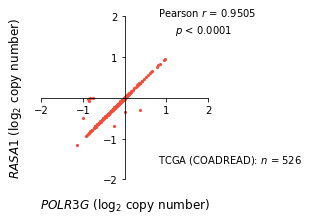

In [39]:
## Plot 
f, ax = plt.subplots(1, 1, figsize=(3,3))

ax = sns.scatterplot(x=x, y=y, color = '#F44E3B', s=10, linewidth=0)
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)

ax.spines['left'].set_position('center')
# move the bottom spine (x axis) up
ax.spines['bottom'].set_position('center')
# turn off the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Set the ticks 
plt.yticks([-2,-1,1,2]); plt.xticks([-2,-1, 1,2])

# x y labels
ax.set_xlabel('$\it{POLR3G}$'+' (log$_2$ copy number)', fontsize=12); ax.set_ylabel('$\it{RASA1}$'+' (log$_2$ copy number)', fontsize=12)

#adjust y-axis label position
ax.yaxis.set_label_coords(-.1, .5)

#adjust x-axis label position 
ax.xaxis.set_label_coords(.5, -.1)

# Pearsons's correlation coefficient 
plt.annotate('Pearson '+'$r$ = {:.4f}'.format(r), xy=(0.7, 1), xycoords='axes fraction')
plt.annotate('$p$ < 0.0001', xy=(0.8, 0.9), xycoords='axes fraction')
plt.annotate('TCGA (COADREAD): $n$ = ' + str(len(x)),xy=(0.7, 0.1), xycoords='axes fraction')

f.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/09_tsg_near_polr3g/rasa1_polr3g_log2_cna_corr_tcga_coadread.pdf', bbox_inches='tight', dpi=400)

**TCGA**: Gene expression between *POLR3G* and *RASA1* in OV/PRAD/COADREAD samples

In [31]:
cna_gistic = pd.read_table('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/09_tsg_near_polr3g/cna_PRAD.txt', index_col=None)
cna_gistic = cna_gistic[['SAMPLE_ID', 'RASA1', 'POLR3G']]
cna_gistic = cna_gistic.rename(columns = {'RASA1':'RASA1_CNA', 'POLR3G':'POLR3G_CNA'})
cna_gistic[:2]

,SAMPLE_ID,RASA1_CNA,POLR3G_CNA
0,TCGA-2A-A8VL-01,0,0
1,TCGA-2A-A8VO-01,0,0


In [32]:
## RSEM 
rnaseq_rsem = pd.read_table('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/09_tsg_near_polr3g/RSEM_PRAD.txt', index_col=None)
rnaseq_rsem = rnaseq_rsem[['SAMPLE_ID', 'POLR3G']].dropna(subset=['POLR3G'])
## Map GISTIC CNA
cna_rnaseq_rsem = pd.merge(cna_gistic, rnaseq_rsem, on = ['SAMPLE_ID'], how='right')
cna_rnaseq_rsem[:5]

,SAMPLE_ID,RASA1_CNA,POLR3G_CNA,POLR3G
0,TCGA-2A-A8VL-01,0,0,31.9258
1,TCGA-2A-A8VO-01,0,0,19.9387
2,TCGA-2A-A8VT-01,-1,-1,43.7500
3,TCGA-2A-A8VV-01,0,0,22.5909
4,TCGA-2A-A8VX-01,0,-2,16.6268


Statistical testing (Mann-Whitney test)

In [33]:
## Strip plot (TCGA)   
plot_df_polr3g = cna_rnaseq_rsem[['POLR3G_CNA', 'POLR3G']]
plot_df_polr3g = plot_df_polr3g[plot_df_polr3g['POLR3G_CNA'] <= 0]

plot_df_rasa1 = cna_rnaseq_rsem[['RASA1_CNA', 'POLR3G']]
plot_df_rasa1 = plot_df_rasa1[plot_df_rasa1['RASA1_CNA'] <= 0]

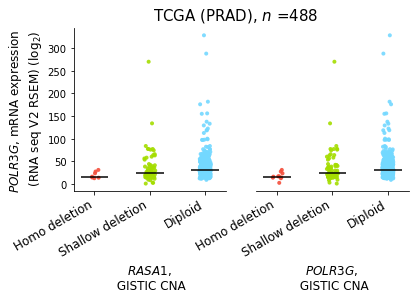

In [34]:
# plot_df = plot_df[plot_df['POLR3GL_CNA'] == 'Diploid']
f, axes = plt.subplots(1, 2, figsize=(6,3), gridspec_kw={'width_ratios': [1,1]}, sharey=True)
plt.suptitle('TCGA (PRAD), $n$ ='+ str(cna_rnaseq_rsem.shape[0]), horizontalalignment='center', fontsize = 15)


## RASA1
ax1 = sns.stripplot(y='POLR3G', x='RASA1_CNA', data=plot_df_rasa1, palette=['#F44E3B', '#A4DD00','#73D8FF'], hue = 'RASA1_CNA', ax=axes[0], alpha=0.9, size=4, zorder=0, jitter=0.1)
ax1.get_legend().remove()
ax1.spines['top'].set_visible(False); ax1.spines['right'].set_visible(False)
# ax1.set_ylabel('$\it{POLR3GL}$, mRNA expression \n Z-score (RNA seq V2 RSEM)', fontsize=12)
ax1.set_ylabel('$\it{POLR3G}$, mRNA expression \n (RNA seq V2 RSEM) (log$_2$)', fontsize=12)
ax1.set_xlabel('$\it{RASA1}$, \n GISTIC CNA', fontsize=12)
ax1.set_xticks([0, 1, 2])
ax1.set_xticklabels(('Homo deletion','Shallow deletion','Diploid'), fontsize=12, rotation=30, ha='right')
# ax1.set_title('$\it{RASA1}$, \n GISTIC CNA', fontsize=12, y = 1.1)
df_median = plot_df_rasa1.groupby('RASA1_CNA')['POLR3G'].median()
_ = [ax1.hlines(y, i-.25, i+.25, zorder=2, colors='black') for i, y in df_median.reset_index()['POLR3G'].items()]


## POLR3G
ax2 = sns.stripplot(y='POLR3G', x='POLR3G_CNA', data=plot_df_polr3g, palette=['#F44E3B', '#A4DD00','#73D8FF'], hue = 'POLR3G_CNA', ax=axes[1], alpha=0.9, size=4, zorder=0, jitter=0.1)
ax2.get_legend().remove()
ax2.spines['top'].set_visible(False); ax2.spines['right'].set_visible(False); ax2.spines['left'].set_visible(False)
ax2.get_yaxis().set_visible(False)
# ax2.set_title('$\it{POLR3G}$, \n GISTIC CNA', fontsize=12, y = 1.1)
ax2.set_xticks([0, 1, 2])
ax2.set_xlabel('$\it{POLR3G}$, \n GISTIC CNA', fontsize=12)
ax2.set_xticklabels(('Homo deletion','Shallow deletion','Diploid'), fontsize=12, rotation=30, ha='right')
df_median = plot_df_polr3g.groupby('POLR3G_CNA')['POLR3G'].median()
_ = [ax2.hlines(y, i-.25, i+.25, zorder=2, colors='black') for i, y in df_median.reset_index()['POLR3G'].items()]
f.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/09_tsg_near_polr3g/polr3g_exp_rasa1_polr3g_gistic_cna_tcga_prad.pdf', bbox_inches='tight', dpi=400)

**CNV of *RASA1* & *POLR3G* and gene essentiality scores in cell lines model (Sanger)**

In [16]:
## CNV data
cnv_sanger = pd.read_csv('/Users/amy/Desktop/SyntheticLethalityProject/1_data_processing/02_BROAD_ID_mapping/cnv_sanger_entrezID_broadID.csv', index_col=None, low_memory=False)
polr3g_rasa1_cnv = cnv_sanger[['BROAD_ID', '10622', '5921']].rename(columns = {'10622':'POLR3G_CNV', '5921':'RASA1_CNV'})
polr3g_rasa1_cnv[:2]

,BROAD_ID,POLR3G_CNV,RASA1_CNV
0,ACH-000956,Neutral,Neutral
1,ACH-000956,Neutral,Neutral


In [17]:
## Gene essentiality score of POLR3GL KO
crispr_broad = pd.read_csv('/Users/amy/Desktop/SyntheticLethalityProject/1_data_processing/04_paralog_genes/crispr_broad_paralog.csv', index_col=None)
polr3gl_crispr = crispr_broad[['BROAD_ID', '84265']].rename(columns = {'84265':'POLR3GL_Chronos'})
polr3gl_crispr[:2]

,BROAD_ID,POLR3GL_Chronos
0,ACH-000001,-0.134404
1,ACH-000004,-0.079947


In [18]:
## Gene expression 
rnaseq_zlogtpm = pd.read_csv('/Users/amy/Desktop/SyntheticLethalityProject/sources/rnaseq_zlogtpm.csv', index_col=None)
rnaseq_zlogtpm = rnaseq_zlogtpm.rename(columns={rnaseq_zlogtpm.columns[0]:'BROAD_ID'})
rnaseq_zlogtpm = rnaseq_zlogtpm[['BROAD_ID', 'POLR3G', 'RASA1']]
rnaseq_zlogtpm[:2]

,BROAD_ID,POLR3G,RASA1
0,ACH-000405,0.650664,0.348625
1,ACH-002340,-1.237590,-0.624545


In [19]:
plot_df = pd.merge(pd.merge(polr3gl_crispr, polr3g_rasa1_cnv, on = ['BROAD_ID'], how = 'left'), rnaseq_zlogtpm, on=['BROAD_ID'], how='left')
plot_df[:1]

,BROAD_ID,POLR3GL_Chronos,POLR3G_CNV,RASA1_CNV,POLR3G,RASA1
0,ACH-000001,-0.134404,Neutral,Neutral,-0.911448,-0.474754


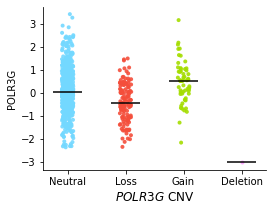

In [20]:
f, ax = plt.subplots(1, 1, figsize=(4,3))
ax = sns.stripplot(y='POLR3G', x='POLR3G_CNV', data=plot_df, palette=['#73D8FF', '#F44E3B', '#A4DD00', '#FDA1FF'], hue = 'POLR3G_CNV', ax=ax, alpha=0.9, size=4, zorder=0, jitter=0.1)
ax.get_legend().remove()
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
# ax1.set_ylabel('$\it{POLR3GL}$, mRNA expression \n Z-score (RNA seq V2 RSEM)', fontsize=12)
# ax.set_ylabel('$\it{POLR3GL}$ dependency score', fontsize=12)
ax.set_xlabel('$\it{POLR3G}$ CNV', fontsize=12)
# ax.set_xticks([0, 1, 2, 3])
# ax.set_xticklabels(('Neural', 'Hetero deletion', 'Gain', 'Amp'), fontsize=12, rotation=30, ha='right')
# ax1.set_title('$\it{RASA1}$, \n GISTIC CNA', fontsize=12, y = 1.1)
df_median = plot_df.groupby('POLR3G_CNV', sort=False)['POLR3G'].median()
_ = [ax.hlines(y, i-.25, i+.25, zorder=2, colors='black') for i, y in df_median.reset_index()['POLR3G'].items()]


**Prostate adenocarcinoma**

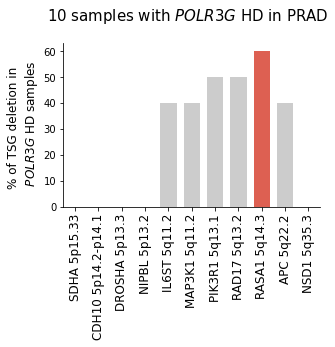

In [16]:
plt_df = codele_freq_df[['TSG', 'PRAD', 'x_label']]
summary_sample_df = tsg_polr3g_CNA[tsg_polr3g_CNA['Study Abbreviation'] == 'PRAD']
fig_output = draw_del_freq(plt_df, summary_sample_df)
fig_output.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/09_tsg_near_polr3g/polr3g_tsg_codele_freq_PRAD.pdf', dpi=400, bbox_inches='tight')
fig_output

**Lung squamous cell carcinoma**

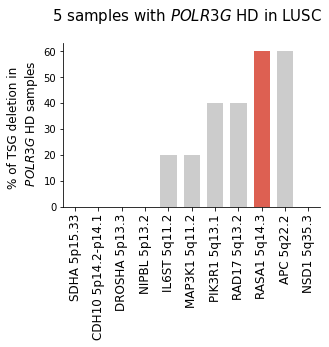

In [17]:
plt_df = codele_freq_df[['TSG', 'LUSC', 'x_label']]
summary_sample_df = tsg_polr3g_CNA[tsg_polr3g_CNA['Study Abbreviation'] == 'LUSC']
fig_output = draw_del_freq(plt_df, summary_sample_df)
fig_output.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/09_tsg_near_polr3g/polr3g_tsg_codele_freq_LUSC.pdf', dpi=400, bbox_inches='tight')
fig_output

**Colorectal Adenocarcinoma**

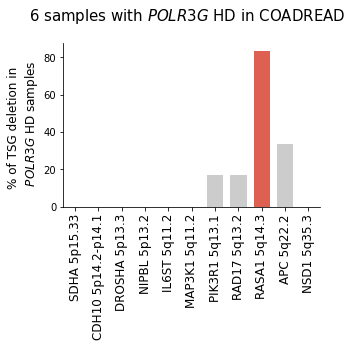

In [18]:
plt_df = codele_freq_df[['TSG', 'COADREAD', 'x_label']]
summary_sample_df = tsg_polr3g_CNA[tsg_polr3g_CNA['Study Abbreviation'] == 'COADREAD']
fig_output = draw_del_freq(plt_df, summary_sample_df)
fig_output.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/09_tsg_near_polr3g/polr3g_tsg_codele_freq_COADREAD.pdf', dpi=400, bbox_inches='tight')
fig_output

### *RASA1*

Ras-GAP SH3 domain inhibits Rho-GAP activity and inhibits tumour development. It has been found that the expression of RASA1 in most tumour cells is associated with intracellular miRNA. 

- Review
    - Ovarian cancer
        - In the development of ovarian cancer, the circular RNA circ-ITCH was revealed to extensively inhibit the viability and motility of ovarian cancer cell lines SK-OV-3 and Caov-3 and dampens tumorigenesis in xenografted NOD mice by upregulating *RASA1* expression (https://doi.org/10.1016/j.bbrc.2018.09.060). It has been funtionally validated. 
    
    - Prostate cancer 
        - *RASA1* has been discovered to be a potential target gene for advanced drug-resistant recurrent prostate cancer by whole transcriptome sequencing. In a genome-wide association study that included 12,518 cases of prostate cancer, *RASA1* was revealed to be associated with aggressive prostate cancer while it exhibited no association with nonaggressive prostate cancer (DOI: 10.1038/ncomms7889).
 
*RASA1* did have role in ovarian and prostate, but the detailed relationship has not been detaily studied.

### *MSH3*

No direct and clear evidence showing the tumorgenesis mechanism caused by *MSH3*.

### *RAD17*

No direct evidence shows that *RAD17* has a tumorgenesis mechanism in ovarian and prostate cancer. 

## Validation

Find the suitable cell line for validation *POLR3GL/POLR3G* synthetic lethality.

The cancer cell line should be with normal copy number of both *POLR3GL* and *POLR3G* gene (diploid).

In [21]:
## CNVV
sanger_cnv = pd.read_csv('/Users/amy/Desktop/SyntheticLethalityProject/sources/WES_pureCN_CNV_genes_total_copy_number_20221213.csv', skiprows=[1,2,3])
sanger_cnv = sanger_cnv.T
sanger_cnv.columns = sanger_cnv.iloc[0]
sanger_cnv = sanger_cnv.iloc[pd.RangeIndex(len(sanger_cnv)).drop(0)]

sanger_cnv_categ = pd.read_csv('/Users/amy/Desktop/SyntheticLethalityProject/sources/WES_pureCN_CNV_genes_cn_category_20221213.csv', skiprows=[1,2,3])
sanger_cnv_categ = sanger_cnv_categ.T
sanger_cnv_categ.columns = sanger_cnv_categ.iloc[0]
sanger_cnv_categ = sanger_cnv_categ.iloc[pd.RangeIndex(len(sanger_cnv_categ)).drop(0)]

In [22]:
## Chronos
Chronos_score = pd.read_csv('/Users/amy/Desktop/SyntheticLethalityProject/1_data_processing/02_BROAD_ID_mapping/crispr_broad_entrezID_broadID.csv', index_col=None)
Chronos_score = Chronos_score[['BROAD_ID', '10622', '84265']]
Chronos_score = Chronos_score.rename(columns={'10622':'POLR3G_Chronos', '84265':'POLR3GL_Chronos'})
Chronos_score[:2]

,BROAD_ID,POLR3G_Chronos,POLR3GL_Chronos
0,ACH-000001,0.053480,-0.134404
1,ACH-000004,-0.094773,-0.079947


In [23]:
## Model info
model_info = pd.read_csv('/Users/amy/Desktop/SyntheticLethalityProject/sources/model_list_20230307.csv', index_col=None)
model_info = model_info[['BROAD_ID', 'tissue', 'cancer_type', 'cancer_type_detail', 'model_name']]
model_info[:2]

,BROAD_ID,tissue,cancer_type,cancer_type_detail,model_name
0,ACH-000205,Pancreas,Pancreatic Carcinoma,Pancreatic Carcinoma,PK-59
1,ACH-000286,Large Intestine,Colorectal Carcinoma,Rectal Adenocarcinoma,SNU-1033


In [24]:
## Only keep cell line with cnv = 2 (diploid)
sanger_cnv = sanger_cnv[['POLR3G', 'POLR3GL']]
sanger_cnv = sanger_cnv[(sanger_cnv['POLR3G'] == 2) & (sanger_cnv['POLR3GL'] == 2)]
# sanger_cnv_categ = sanger_cnv_categ[['POLR3G', 'POLR3GL']]
# sanger_cnv_categ = sanger_cnv_categ[(sanger_cnv_categ['POLR3G'] == 'Neutral') & (sanger_cnv_categ['POLR3GL'] == 'Neutral')]
# sanger_cnv_categ = sanger_cnv_categ.rename(columns={'POLR3G':'POLR3G_categ', 'POLR3GL':'POLR3GL_categ'})
# cnv = pd.merge(sanger_cnv, sanger_cnv_categ, left_index=True, right_index=False)
# cnv = cnv[(cnv['POLR3G'] == 2) & (cnv['POLR3G_categ']=='Neutral') ]
sanger_cnv['model_name'] = sanger_cnv.index

cnv_model = pd.merge(sanger_cnv, model_info, on=['model_name'], how ='left')

cnv_model = pd.merge(Chronos_score, cnv_model, on = ['BROAD_ID'], how = 'right')
cnv_model.to_csv('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/09_tsg_near_polr3g/cl_model_polr3g_polr3gl_diploid.csv', index=False)
cnv_model[:2]

,BROAD_ID,POLR3G_Chronos,POLR3GL_Chronos,POLR3G,POLR3GL,model_name,tissue,cancer_type,cancer_type_detail
0,ACH-000973,-0.043066,-0.068438,2.0,2.0,639-V,Bladder,Bladder Carcinoma,Bladder Carcinoma
1,ACH-000070,0.007227,-0.072117,2.0,2.0,697,Haematopoietic and Lymphoid,B-Lymphoblastic Leukemia,Childhood B Acute Lymphoblastic Leukemia


In [25]:
model = cnv_model[(cnv_model['cancer_type'] == 'Ovarian Carcinoma') | (cnv_model['cancer_type'] == 'Prostate Carcinoma')].sort_values(by=['cancer_type'])
model.to_csv('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/09_tsg_near_polr3g/ov_prad_model_polr3g_polr3gl_diploid.csv', index=False)

In [26]:
model

,BROAD_ID,POLR3G_Chronos,POLR3GL_Chronos,POLR3G,POLR3GL,model_name,tissue,cancer_type,cancer_type_detail
6,ACH-000657,-0.185710,-0.091609,2.0,2.0,A2780,Ovary,Ovarian Carcinoma,Ovarian Endometrioid Adenocarcinoma
323,ACH-000701,-0.152209,0.086169,2.0,2.0,RMUG-S,Ovary,Ovarian Carcinoma,Ovarian Cystadenocarcinoma
322,ACH-000719,-0.081018,-0.008727,2.0,2.0,RMG-I,Ovary,Ovarian Carcinoma,Ovarian Clear Cell Adenocarcinoma
305,ACH-001374,-0.138628,0.158436,2.0,2.0,PA-1,Ovary,Ovarian Carcinoma,Ovarian Mixed Germ Cell Tumor
301,ACH-002183,0.330247,0.032820,2.0,2.0,OVMIU,Ovary,Ovarian Carcinoma,High Grade Ovarian Serous Adenocarcinoma
299,ACH-000291,-0.060467,-0.152030,2.0,2.0,OV-90,Ovary,Ovarian Carcinoma,Ovarian Adenocarcinoma
298,ACH-000688,-0.185748,-0.100482,2.0,2.0,OV-7,Ovary,Ovarian Carcinoma,Ovarian Carcinoma
297,ACH-000091,NaN,NaN,2.0,2.0,OV-56,Ovary,Ovarian Carcinoma,Ovarian Serous Adenocarcinoma
344,ACH-000811,-0.094115,-0.144217,2.0,2.0,SK-OV-3,Ovary,Ovarian Carcinoma,Ovarian Serous Cystadenocarcinoma
394,ACH-000885,0.034213,-0.077075,2.0,2.0,TOV-21G,Ovary,Ovarian Carcinoma,Ovarian Clear Cell Adenocarcinoma
